# Binary Classification Model for Rain in Australia Using Python Take 2
### David Lowe
### March 27, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Rain in Australia dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset contains daily weather observations from numerous Australian weather stations. The target variable RainTomorrow represents whether it rained the next day. We also should exclude the variable Risk-MM when training a binary classification model. By not eliminating the Risk-MM feature, we run a risk of leaking the answers into our model and reduce its effectiveness.

In iteration Take1, we constructed several traditional machine learning models using the linear, non-linear, and ensemble techniques. We also observed the best accuracy score that we could obtain with each of these models.

In this Take2 iteration, we will construct and tune an XGBoost machine learning model for this dataset. We will observe the best accuracy score that we can obtain with the XGBoost model.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average accuracy of 83.83%. Two algorithms (Extra Trees and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Random Forest turned in a better overall result than Extra Trees with a lower variance. Random Forest achieved an accuracy metric of 85.44%. When configured with the optimized parameters, the Random Forest algorithm processed the test dataset with an accuracy of 85.52%, which was consistent with the accuracy score from the training phase.

In this Take2 iteration, the XGBoost algorithm achieved a baseline accuracy of 84.69% by setting n_estimators to the default value of 100. After a series of tuning trials, XGBoost turned in an overall accuracy result of 86.21% with the n_estimators value set to 1000. When we apply the tuned XGBoost model to the test dataset, we obtained an accuracy score of 86.27%, which was consistent with the model performance from the training phase.

CONCLUSION: For this iteration, the XGBoost algorithm achieved the best overall result using the training and test datasets. For this dataset, XGBoost should be considered for further modeling.

Dataset Used: Rain in Australia Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

One potential source of performance benchmark: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/kernels

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

In [1]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Mar 22 16:34:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


### 1.a) Load libraries and modules

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

# Set various Pandas options
pd.set_option('display.max_rows', 9999)

In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-rain-tomorrow-australia/weatherAUS.csv'

Xy_original = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_original.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,0.0,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,1.4,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0.0,No


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

In [10]:
Xy_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [11]:
Xy_original.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [12]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  316559


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'RainTomorrow': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['Date','RISK_MM'], inplace=True)

# Impute missing values
Xy_original['MinTemp'].fillna(value=Xy_original['MinTemp'].median(), inplace=True)
Xy_original['MaxTemp'].fillna(value=Xy_original['MaxTemp'].median(), inplace=True)
Xy_original['Rainfall'].fillna(0.0, inplace=True)
Xy_original['Evaporation'].fillna(0.0, inplace=True)
Xy_original['Sunshine'].fillna(value=Xy_original['Sunshine'].median(), inplace=True)
Xy_original['WindGustDir'].fillna("UNKNOWN", inplace=True)
Xy_original['WindGustSpeed'].fillna(0, inplace=True)
Xy_original['WindDir9am'].fillna("UNKNOWN", inplace=True)
Xy_original['WindDir3pm'].fillna("UNKNOWN", inplace=True)
Xy_original['WindSpeed9am'].fillna(0, inplace=True)
Xy_original['WindSpeed3pm'].fillna(0, inplace=True)
Xy_original['Humidity9am'].fillna(value=Xy_original['Humidity9am'].median(), inplace=True)
Xy_original['Humidity3pm'].fillna(value=Xy_original['Humidity3pm'].median(), inplace=True)
Xy_original['Pressure9am'].fillna(value=Xy_original['Pressure9am'].median(), inplace=True)
Xy_original['Pressure3pm'].fillna(value=Xy_original['Pressure3pm'].median(), inplace=True)
Xy_original['Cloud9am'].fillna(value=Xy_original['Cloud9am'].median(), inplace=True)
Xy_original['Cloud3pm'].fillna(value=Xy_original['Cloud3pm'].median(), inplace=True)
Xy_original['Temp9am'].fillna(value=Xy_original['Temp9am'].median(), inplace=True)
Xy_original['Temp3pm'].fillna(value=Xy_original['Temp3pm'].median(), inplace=True)
Xy_original['RainToday'].fillna("No", inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
Xy_original['Location'] = Xy_original['Location'].astype('category')
Xy_original['WindGustDir'] = Xy_original['WindGustDir'].astype('category')
Xy_original['WindDir9am'] = Xy_original['WindDir9am'].astype('category')
Xy_original['WindDir3pm'] = Xy_original['WindDir3pm'].astype('category')
Xy_original['RainToday'] = Xy_original['RainToday'].astype('category')

# Convert features with Yes/No levels into categorical feature of 1/0
def reClassRainTomorrow(target):
    if (target == 'Yes'): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['RainTomorrow'].apply(reClassRainTomorrow)
Xy_original.drop(columns=['RainTomorrow'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,targetVar
0,Albury,13.4,22.9,0.6,0.0,8.5,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,0
1,Albury,7.4,25.1,0.0,0.0,8.5,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,0
2,Albury,12.9,25.7,0.0,0.0,8.5,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,0
3,Albury,9.2,28.0,0.0,0.0,8.5,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,0
4,Albury,17.5,32.3,1.0,0.0,8.5,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
5,Albury,14.6,29.7,0.2,0.0,8.5,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,No,0
6,Albury,14.3,25.0,0.0,0.0,8.5,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,5.0,18.1,24.6,No,0
7,Albury,7.7,26.7,0.0,0.0,8.5,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,No,0
8,Albury,9.7,31.9,0.0,0.0,8.5,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,5.0,5.0,18.3,30.2,No,1
9,Albury,13.1,30.1,1.4,0.0,8.5,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,5.0,5.0,20.1,28.2,Yes,0


In [14]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
Location         142193 non-null category
MinTemp          142193 non-null float64
MaxTemp          142193 non-null float64
Rainfall         142193 non-null float64
Evaporation      142193 non-null float64
Sunshine         142193 non-null float64
WindGustDir      142193 non-null category
WindGustSpeed    142193 non-null float64
WindDir9am       142193 non-null category
WindDir3pm       142193 non-null category
WindSpeed9am     142193 non-null float64
WindSpeed3pm     142193 non-null float64
Humidity9am      142193 non-null float64
Humidity3pm      142193 non-null float64
Pressure9am      142193 non-null float64
Pressure3pm      142193 non-null float64
Cloud9am         142193 non-null float64
Cloud3pm         142193 non-null float64
Temp9am          142193 non-null float64
Temp3pm          142193 non-null float64
RainToday        142193 non-null category
targetVar        142193

In [15]:
Xy_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,targetVar
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,12.185565,23.225365,2.326738,3.129340,8.042236,37.377592,13.869248,18.292855,68.858235,51.495742,1017.648460,1015.252481,4.649568,4.702658,16.985681,21.675977,0.224181
std,6.388936,7.109617,8.426426,4.166674,2.769638,16.433198,8.954477,9.075870,18.932512,20.532227,6.746267,6.681810,2.294357,2.118753,6.472206,6.871243,0.417043
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,0.000000,8.200000,30.000000,7.000000,11.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000,0.000000
50%,12.000000,22.600000,0.000000,1.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [16]:
Xy_original.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
targetVar        0
dtype: int64

In [17]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (142193, 22) X_original.shape: (142193, 21) y_original.shape: (142193,)


### 1.f) Set up the parameters for data visualization

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [0]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [23]:
X_original.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,0.0,8.5,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No
1,Albury,7.4,25.1,0.0,0.0,8.5,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No
2,Albury,12.9,25.7,0.0,0.0,8.5,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,0.0,8.5,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No
4,Albury,17.5,32.3,1.0,0.0,8.5,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
5,Albury,14.6,29.7,0.2,0.0,8.5,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,No
6,Albury,14.3,25.0,0.0,0.0,8.5,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,5.0,18.1,24.6,No
7,Albury,7.7,26.7,0.0,0.0,8.5,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,No
8,Albury,9.7,31.9,0.0,0.0,8.5,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,5.0,5.0,18.3,30.2,No
9,Albury,13.1,30.1,1.4,0.0,8.5,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,5.0,5.0,20.1,28.2,Yes


#### 2.a.ii) Dimensions and attribute types

In [24]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
Location         142193 non-null category
MinTemp          142193 non-null float64
MaxTemp          142193 non-null float64
Rainfall         142193 non-null float64
Evaporation      142193 non-null float64
Sunshine         142193 non-null float64
WindGustDir      142193 non-null category
WindGustSpeed    142193 non-null float64
WindDir9am       142193 non-null category
WindDir3pm       142193 non-null category
WindSpeed9am     142193 non-null float64
WindSpeed3pm     142193 non-null float64
Humidity9am      142193 non-null float64
Humidity3pm      142193 non-null float64
Pressure9am      142193 non-null float64
Pressure3pm      142193 non-null float64
Cloud9am         142193 non-null float64
Cloud3pm         142193 non-null float64
Temp9am          142193 non-null float64
Temp3pm          142193 non-null float64
RainToday        142193 non-null category
dtypes: category(5), fl

#### 2.a.iii) Statistical summary of the attributes

In [25]:
X_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,12.185565,23.225365,2.326738,3.129340,8.042236,37.377592,13.869248,18.292855,68.858235,51.495742,1017.648460,1015.252481,4.649568,4.702658,16.985681,21.675977
std,6.388936,7.109617,8.426426,4.166674,2.769638,16.433198,8.954477,9.075870,18.932512,20.532227,6.746267,6.681810,2.294357,2.118753,6.472206,6.871243
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,0.000000,8.200000,30.000000,7.000000,11.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000
50%,12.000000,22.600000,0.000000,1.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


#### 2.a.iv) Summarize the levels of the class attribute

In [26]:
Xy_original.groupby('targetVar').size()

targetVar
0    110316
1     31877
dtype: int64

### 2.b) Data Visualization

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

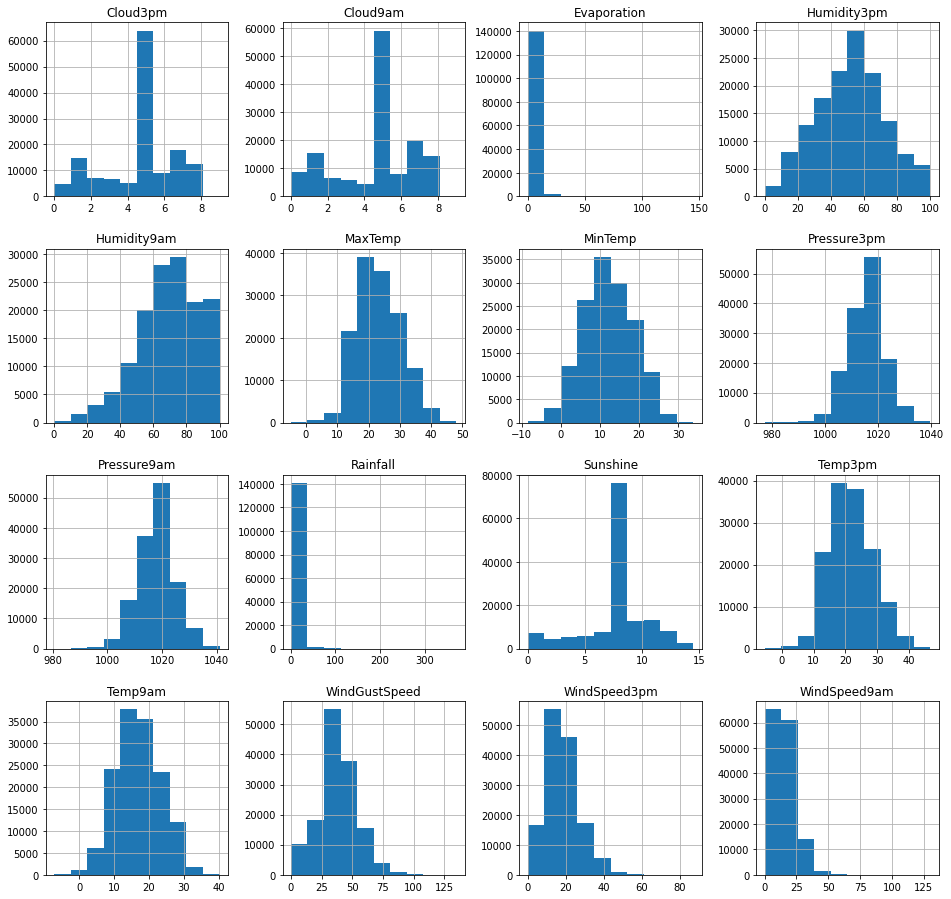

In [27]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

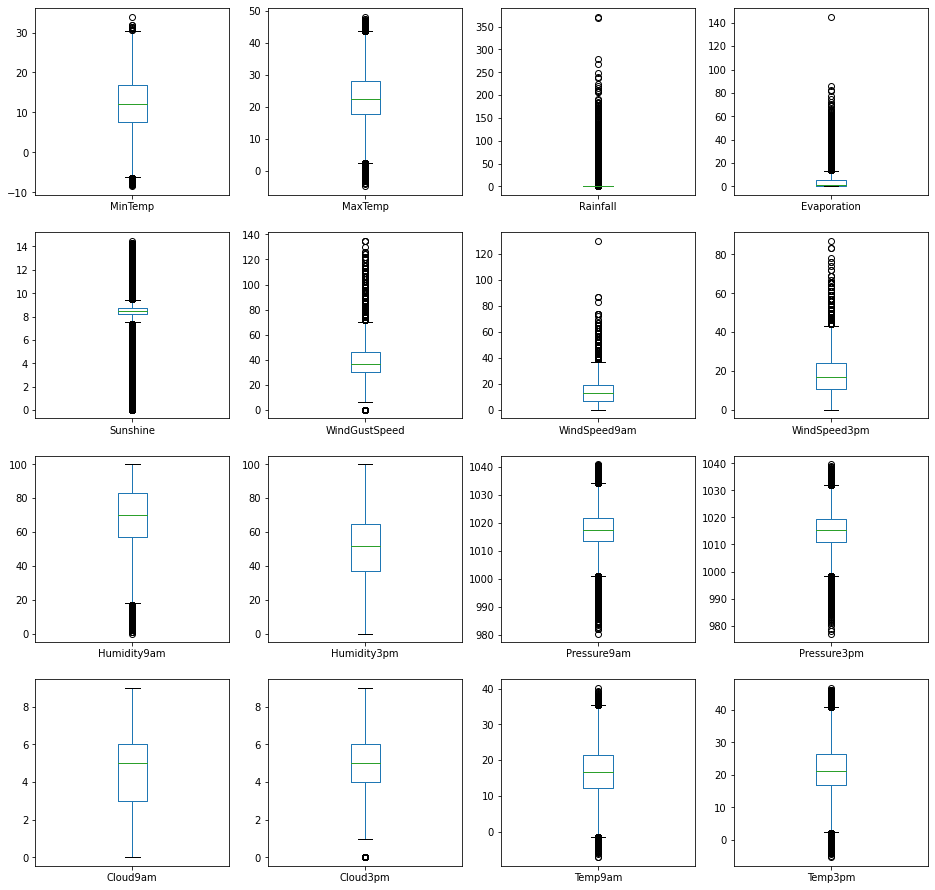

In [28]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

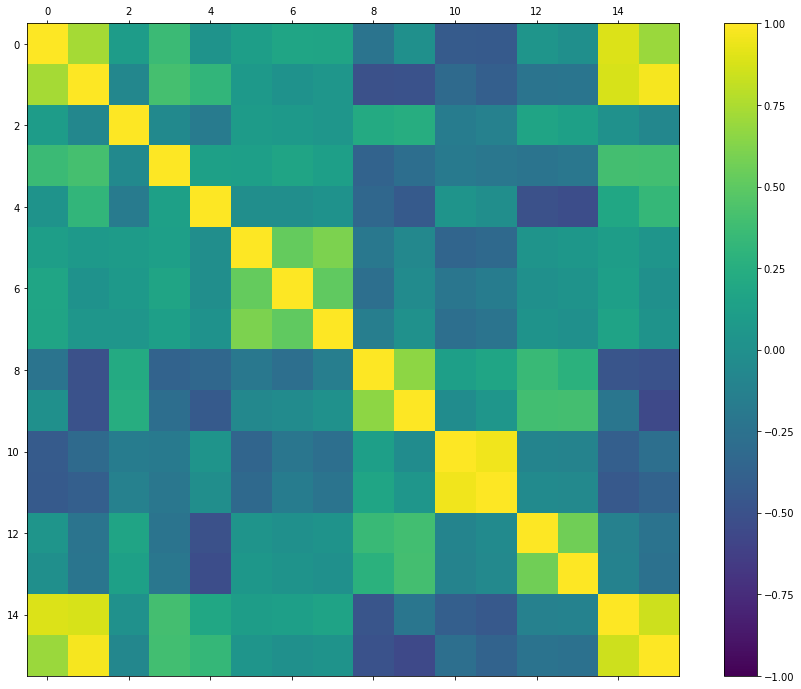

In [29]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [32]:
# Apply feature scaling techniques
X_original['MinTemp'] = preprocessing.scale(X_original['MinTemp'])
X_original['MaxTemp'] = preprocessing.scale(X_original['MaxTemp'])
X_original['Rainfall'] = preprocessing.scale(X_original['Rainfall'])
X_original['Evaporation'] = preprocessing.scale(X_original['Evaporation'])
X_original['Sunshine'] = preprocessing.scale(X_original['Sunshine'])
X_original['WindGustSpeed'] = preprocessing.scale(X_original['WindGustSpeed'])
X_original['WindSpeed9am'] = preprocessing.scale(X_original['WindSpeed9am'])
X_original['WindSpeed3pm'] = preprocessing.scale(X_original['WindSpeed3pm'])
X_original['Humidity9am'] = preprocessing.scale(X_original['Humidity9am'])
X_original['Humidity3pm'] = preprocessing.scale(X_original['Humidity3pm'])
X_original['Pressure9am'] = preprocessing.scale(X_original['Pressure9am'])
X_original['Pressure3pm'] = preprocessing.scale(X_original['Pressure3pm'])
X_original['Cloud9am'] = preprocessing.scale(X_original['Cloud9am'])
X_original['Cloud3pm'] = preprocessing.scale(X_original['Cloud3pm'])
X_original['Temp9am'] = preprocessing.scale(X_original['Temp9am'])
X_original['Temp3pm'] = preprocessing.scale(X_original['Temp3pm'])
    
print(X_original.head(-10))

       Location   MinTemp   MaxTemp  ...   Temp9am   Temp3pm  RainToday
0        Albury  0.190085 -0.045764  ... -0.013238  0.018050         No
1        Albury -0.749042  0.263677  ...  0.033114  0.381886         No
2        Albury  0.111824  0.348070  ...  0.620242  0.221798         No
3        Albury -0.467304  0.671577  ...  0.172171  0.702062         No
4        Albury  0.831821  1.276393  ...  0.125818  1.167773         No
...         ...       ...       ...  ...       ...       ...        ...
142178    Uluru -1.406431 -0.650581  ... -1.357452 -0.622303         No
142179    Uluru -1.531648 -0.580253  ... -1.388354 -0.418554         No
142180    Uluru -1.109041 -0.495860  ... -1.311100 -0.360340         No
142181    Uluru -1.515996 -0.284878  ... -1.032987 -0.200252         No
142182    Uluru -1.547300 -0.256747  ... -1.249297 -0.200252         No

[142183 rows x 21 columns]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

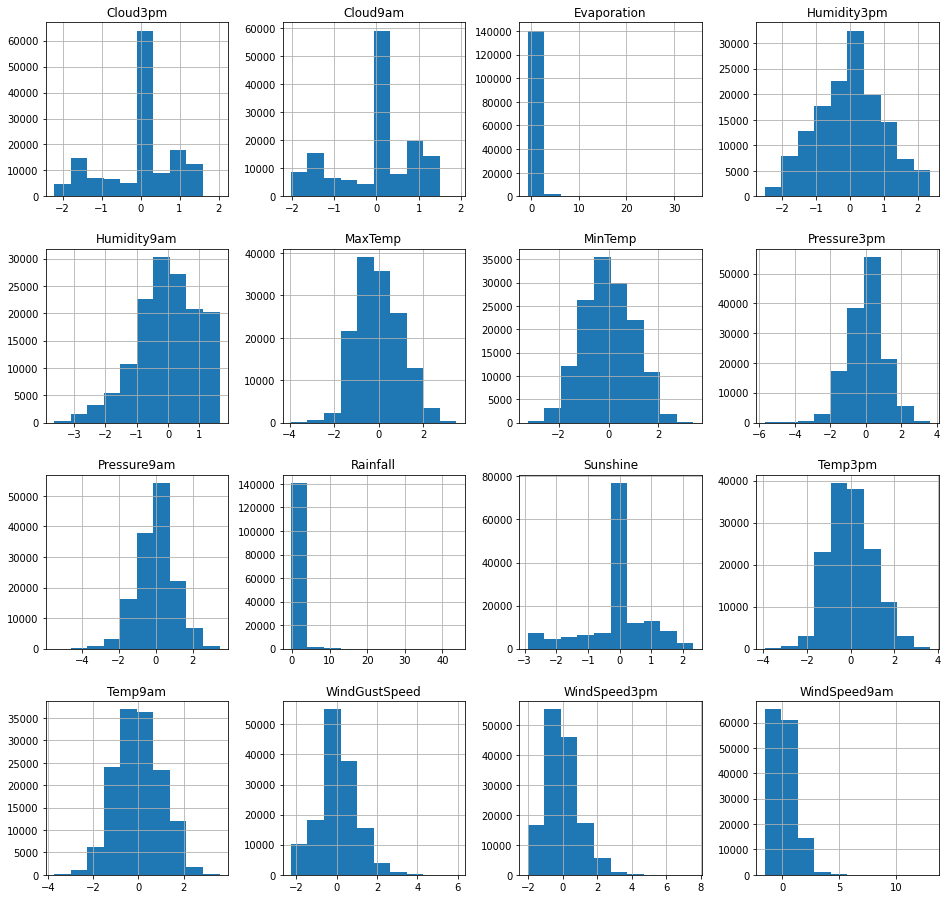

In [33]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

### 3.b) Apply One-Hot-Encoding to Categorical Features

In [34]:
# Perform one-hot-encoding on the categorical attributes
X_original = pd.get_dummies(X_original)
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 118 columns):
MinTemp                      float64
MaxTemp                      float64
Rainfall                     float64
Evaporation                  float64
Sunshine                     float64
WindGustSpeed                float64
WindSpeed9am                 float64
WindSpeed3pm                 float64
Humidity9am                  float64
Humidity3pm                  float64
Pressure9am                  float64
Pressure3pm                  float64
Cloud9am                     float64
Cloud3pm                     float64
Temp9am                      float64
Temp3pm                      float64
Location_Adelaide            uint8
Location_Albany              uint8
Location_Albury              uint8
Location_AliceSprings        uint8
Location_BadgerysCreek       uint8
Location_Ballarat            uint8
Location_Bendigo             uint8
Location_Brisbane            uint8
Location_Cairns 

### 3.c) Training Data Balancing

In [0]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [0]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [37]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (106644, 118) y_train_df.shape: (106644,)
X_test_df.shape: (35549, 118) y_test_df.shape: (35549,)


In [38]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (106644, 118) y_train.shape: (106644,)
X_test.shape: (35549, 118) y_test.shape: (35549,)


In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [0]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
# train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
# train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
# train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
# train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')))

In [41]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	print('Cross Validation Results:', cv_results)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validation Results: [0.85320456 0.86042477 0.84968822 0.85447044 0.85291635]
RNF: 0.854141 (0.003516)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)
Model training time: 0:00:40.307196 



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Cross Validation Results: [0.84645319 0.8524544  0.84298373 0.84776595 0.84489872]
XGB: 0.846911 (0.003198)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
Model training time: 0:00:05.663204 

Average metrics (accuracy) from all models: 0.8505260341088602
Total training time for all models: 0:00:05.664063


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


### 4.b) Spot-checking baseline algorithms

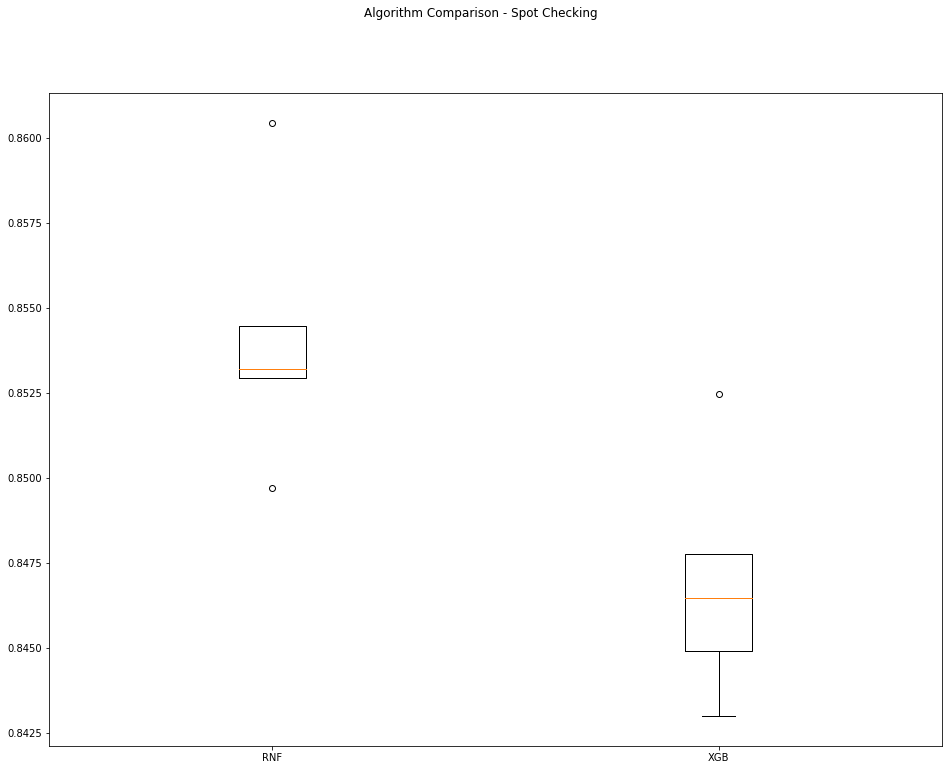

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [0]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [44]:
# Tuning algorithm #1 - Random Forest
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([100, 250, 500, 750, 1000]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)
print('Grid Search Results:', grid_result1)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 17.2min finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                  

In [45]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 1000


In [46]:
# Tuning algorithm #2 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid2 = dict(n_estimators=np.array([100, 250, 500, 750, 1000]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result2 = grid2.fit(X_train, y_train)
print('Grid Search Results:', grid_result2)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.1s finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=888, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     tree_method='gpu_hist', verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estim

In [47]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 1000


In [48]:
# Tuning algorithm #3 - XGBoost with More Tuning
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #3 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model3 = XGBClassifier(n_estimators=1000, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid3 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 3, 5]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid3 = GridSearchCV(estimator=tune_model3, param_grid=paramGrid3, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result3 = grid3.fit(X_train, y_train)
print('Grid Search Results:', grid_result3)

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
tune_results.append(grid_result3.cv_results_['mean_test_score'])
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #3 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  8.6min finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=888, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     tree_method='gpu_hist', verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_de

In [49]:
# Tuning algorithm #4 - XGBoost with More Tuning
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #3 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model4 = XGBClassifier(n_estimators=2000, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB_3')
paramGrid4 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 3, 5]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid4 = GridSearchCV(estimator=tune_model4, param_grid=paramGrid4, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result4 = grid4.fit(X_train, y_train)
print('Grid Search Results:', grid_result4)

print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
tune_results.append(grid_result4.cv_results_['mean_test_score'])
means = grid_result4.cv_results_['mean_test_score']
stds = grid_result4.cv_results_['std_test_score']
params = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #4 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 16.2min finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=2000, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=888, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     tree_method='gpu_hist', verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_de

### 5.b) Compare Algorithms After Tuning

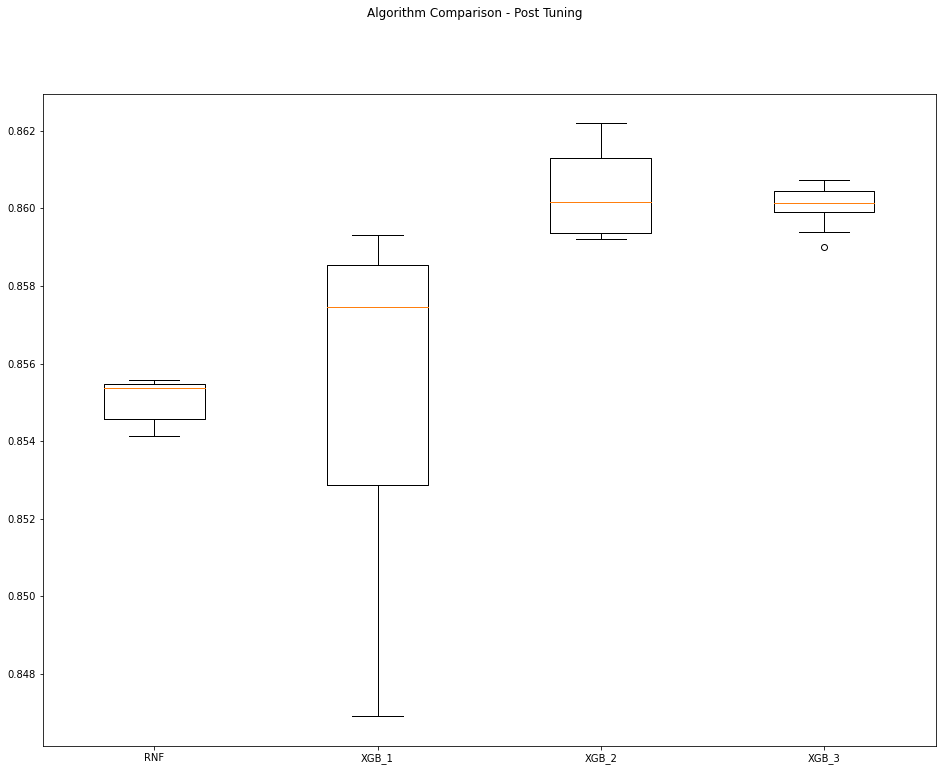

In [50]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [52]:
test_model1 = RandomForestClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.8570423921910603
ROC/AUC Score: 0.7324009593556468
[[26431  1149]
 [ 3933  4036]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     27580
           1       0.78      0.51      0.61      7969

    accuracy                           0.86     35549
   macro avg       0.82      0.73      0.76     35549
weighted avg       0.85      0.86      0.85     35549

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)


In [53]:
test_model2 = XGBClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.8597428900953613
ROC/AUC Score: 0.7490424438389841
[[26193  1387]
 [ 3599  4370]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27580
           1       0.76      0.55      0.64      7969

    accuracy                           0.86     35549
   macro avg       0.82      0.75      0.77     35549
weighted avg       0.85      0.86      0.85     35549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


In [54]:
test_model3 = XGBClassifier(n_estimators=1000, max_depth=6, min_child_weight=3,
                            random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
test_model3.fit(X_train, y_train)
predictions3 = test_model3.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions3))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions3))
print(confusion_matrix(y_test, predictions3))
print(classification_report(y_test, predictions3))
print(test_model3)

Accuracy Score: 0.8627528200511969
ROC/AUC Score: 0.7607527323745722
[[26081  1499]
 [ 3380  4589]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.91     27580
           1       0.75      0.58      0.65      7969

    accuracy                           0.86     35549
   macro avg       0.82      0.76      0.78     35549
weighted avg       0.86      0.86      0.86     35549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


In [55]:
test_model4 = XGBClassifier(n_estimators=2000, max_depth=3, min_child_weight=3,
                            random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
test_model4.fit(X_train, y_train)
predictions4 = test_model4.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions4))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions4))
print(confusion_matrix(y_test, predictions4))
print(classification_report(y_test, predictions4))
print(test_model4)

Accuracy Score: 0.8611493994205182
ROC/AUC Score: 0.7536964780402231
[[26159  1421]
 [ 3515  4454]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27580
           1       0.76      0.56      0.64      7969

    accuracy                           0.86     35549
   macro avg       0.82      0.75      0.78     35549
weighted avg       0.85      0.86      0.85     35549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


### 6.b) Create a standalone model using all available data

In [0]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [0]:
# modelName = 'FinalModel_BinaryClass.sav'
# dump(final_model, modelName)

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:47:49.814755
